In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import time
import tqdm
import random
import argparse

import numpy as np
import pandas as pd
tqdm.tqdm.pandas()

import matplotlib.pyplot as plt

import gensim
from gensim import corpora, models, similarities

from sklearn.model_selection import train_test_split

from mlxtend.plotting import plot_confusion_matrix

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, preprocessing
from tensorflow.keras.utils import to_categorical

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=ConvergenceWarning)

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [2]:
set_seed(42)

In [3]:
df = pd.read_csv("/mnt/d/work2/teknofest-tddi/data/processed/cleaned.csv")
df = df.dropna()
df = df.reset_index(drop=True)

In [4]:
df.head()

,rid,sid,app,review,sentiment,aspect,aspect_polarity,cleaned,text
0,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
1,9,1,Google Play Store/BiP,Uygulamada kartlarda Troy kart geçmiyor Lütfen...,Positive,Troy,2,Uygulamada kartlarda Troy kart geçmiyor uygula...,Troy Uygulamada kartlarda Troy kart geçmiyor u...
2,10,1,Google Play Store/BiP,Her güncellemede daha da kötüleşen Turkcell in...,Negative,Turkcell,0,güncellemede kötüleşen Turkcell in ara ara ken...,Turkcell güncellemede kötüleşen Turkcell in ar...
3,13,1,Google Play Store/BiP,BiP’ten aranmıyor yardım,Negative,BiP’ten,0,BiPten aranmıyor yardım,BiP’ten BiPten aranmıyor yardım
4,17,1,Google Play Store/BiP,Bu yorumum kesinlikle uygulamanın daha çok gel...,Positive,BİP,2,yorumum uygulamanın gelişmesi kulanıcıya erişi...,BİP yorumum uygulamanın gelişmesi kulanıcıya e...


In [5]:
df["text"] = df["aspect"] + " " + df["cleaned"]

In [6]:
X = df["text"]
y = df["aspect_polarity"]

In [7]:
def train_validate_test_split(df, split_size):
    perm = np.random.permutation(df.index)
    train_end = int(split_size * len(df.index))
    validate_end = int(((1 - split_size) / 2) * len(df.index)) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [8]:
df_train, df_validation, df_test = train_validate_test_split(df, split_size=0.9)

In [9]:
X_train = df_train["text"]
y_train = df_train["aspect_polarity"]

In [10]:
X_valid = df_validation["text"]
y_valid = df_validation["aspect_polarity"]

In [11]:
X_test = df_test["text"]
y_test = df_test["aspect_polarity"]

In [12]:
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

In [13]:
tokenizer = preprocessing.text.Tokenizer(
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
    lower = False,
    split = " "
)
tokenizer.fit_on_texts(X)

In [14]:
X_train_tokenizer = tokenizer.texts_to_sequences(X_train)
X_valid_tokenizer = tokenizer.texts_to_sequences(X_valid)
X_test_tokenizer = tokenizer.texts_to_sequences(X_test)

In [15]:
maxlen = 65
X_train_tokenizer = preprocessing.sequence.pad_sequences(X_train_tokenizer, maxlen=maxlen)
X_valid_tokenizer = preprocessing.sequence.pad_sequences(X_valid_tokenizer, maxlen=maxlen)
X_test_tokenizer = preprocessing.sequence.pad_sequences(X_test_tokenizer, maxlen=maxlen)

In [16]:
input_dim = len(tokenizer.word_index) + 1
input_dim

103649

In [17]:
documents = [_text.split() for _text in df["text"]]

In [18]:
w2v_model = gensim.models.word2vec.Word2Vec(
    vector_size = 100,
    window = 2,
    min_count = 10,
    workers = 10
)

In [19]:
w2v_model.build_vocab(documents)

In [20]:
vocab_len = len(w2v_model.wv)
vocab_len

23630

In [21]:
w2v_model.train(documents, total_examples=len(documents), epochs=16)

(38734536, 46927632)

In [22]:
wv_embedding_matrix = np.zeros((input_dim, 100))
for word, i in tqdm.tqdm(tokenizer.word_index.items()):
    if word in w2v_model.wv:
        wv_embedding_matrix[i] = w2v_model.wv[word]

100%|██████████████████████████████████████████████████████████| 103648/103648 [00:00<00:00, 1043161.32it/s]


In [23]:
model = models.Sequential([
    layers.Input(shape=X_train_tokenizer.shape[1]),
    layers.Embedding(len(tokenizer.word_index)+1, 100, weights=[wv_embedding_matrix], input_length=maxlen, trainable=False),
    layers.Bidirectional(layers.LSTM(100, return_sequences=True)),
    layers.GlobalMaxPooling1D(),
    layers.Dense(3, activation='softmax')
])

In [24]:
model.compile(loss='categorical_crossentropy', 
                  optimizer=tf.keras.optimizers.legacy.Adam(), 
                  metrics=['accuracy'])   

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 100)           10364900  
                                                                 
 bidirectional (Bidirectiona  (None, 65, 200)          160800    
 l)                                                              
                                                                 
 global_max_pooling1d (Globa  (None, 200)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 3)                 603       
                                                                 
Total params: 10,526,303
Trainable params: 161,403
Non-trainable params: 10,364,900
_________________________________________________________________


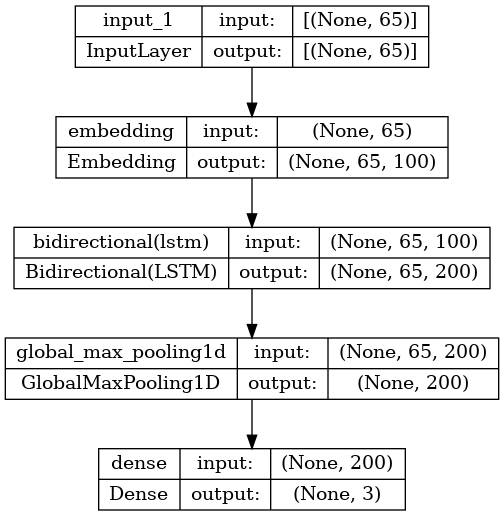

In [26]:
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True, to_file="./output/bilstm_word2vec_model_plot.png")

In [27]:
model1_train_start = time.time()
model_history = model.fit(
    X_train_tokenizer, 
    y_train, 
    epochs=10, 
    batch_size=128, 
    validation_data=[X_valid_tokenizer, y_valid], 
    callbacks=[callbacks.EarlyStopping(monitor="val_accuracy", patience=3)]
)
model1_train_time = time.time() - model1_train_start
print(f"Bi-LSTM Train Time = {model1_train_time:.4f}")

Epoch 1/10
1141/1141 [==============================] - 79s 68ms/step - loss: 0.5707 - accuracy: 0.7714 - val_loss: 0.5372 - val_accuracy: 0.7856
Epoch 2/10
1141/1141 [==============================] - 77s 68ms/step - loss: 0.5091 - accuracy: 0.8001 - val_loss: 0.5042 - val_accuracy: 0.8020
Epoch 3/10
1141/1141 [==============================] - 76s 67ms/step - loss: 0.4608 - accuracy: 0.8224 - val_loss: 0.4983 - val_accuracy: 0.8079
Epoch 4/10
1141/1141 [==============================] - 78s 69ms/step - loss: 0.4119 - accuracy: 0.8442 - val_loss: 0.4591 - val_accuracy: 0.8272
Epoch 5/10
1141/1141 [==============================] - 79s 69ms/step - loss: 0.3665 - accuracy: 0.8645 - val_loss: 0.4519 - val_accuracy: 0.8298
Epoch 6/10
1141/1141 [==============================] - 80s 70ms/step - loss: 0.3258 - accuracy: 0.8813 - val_loss: 0.4380 - val_accuracy: 0.8410
Epoch 7/10
1141/1141 [==============================] - 77s 67ms/step - loss: 0.2898 - accuracy: 0.8965 - val_loss: 0.4393 -

In [28]:
model1_test_start = time.time()
model_pred_test = model.predict(X_test_tokenizer, verbose=0)
model1_test_time = time.time() - model1_test_start
print(f"Bi-LSTM Test Time = {model1_test_time:.4f}")

Bi-LSTM Test Time = 3.4468


In [29]:
true_labels_train = np.argmax(y_train, axis=1)
true_labels_test = np.argmax(y_test, axis=1)

In [30]:
model_pred_train = model.predict(X_train_tokenizer, verbose=0)
model_pred_train = np.argmax(model_pred_train, axis=1)
model_pred_test = np.argmax(model_pred_test, axis=1)
model_train_score = accuracy_score(model_pred_train, true_labels_train)
model_test_score = accuracy_score(model_pred_test, true_labels_test)
print(f"Bi-LSTM Train Score = {model_train_score * 100:.4f}%")
print(f"Bi-LSTM Test Score = {model_test_score * 100:.4f}%")

Bi-LSTM Train Score = 94.7257%
Bi-LSTM Test Score = 84.5955%


In [31]:
model_precision_score = precision_score(true_labels_test, model_pred_test, average="macro")
model_f1_score = f1_score(true_labels_test, model_pred_test, average="macro")
model_recall_score = recall_score(true_labels_test, model_pred_test, average="macro")
model_accuracy_score = accuracy_score(true_labels_test, model_pred_test)

print(f"Bi-LSTM Precision Score = {model_precision_score * 100:.4f}%")
print(f"Bi-LSTM F1 Score = {model_f1_score * 100:.4f}%")
print(f"Bi-LSTM Recall Score = {model_recall_score * 100:.4f}%")
print(f"Bi-LSTM Accuracy Score = {model_accuracy_score * 100:.4f}%")

Bi-LSTM Precision Score = 77.4582%
Bi-LSTM F1 Score = 71.3395%
Bi-LSTM Recall Score = 68.5494%
Bi-LSTM Accuracy Score = 84.5955%


In [32]:
print(classification_report(true_labels_test, model_pred_test, target_names=["Negative", "Neutral", "Positive"]))

              precision    recall  f1-score   support

    Negative       0.86      0.90      0.88      4508
     Neutral       0.62      0.32      0.42       421
    Positive       0.84      0.84      0.84      3179

    accuracy                           0.85      8108
   macro avg       0.77      0.69      0.71      8108
weighted avg       0.84      0.85      0.84      8108



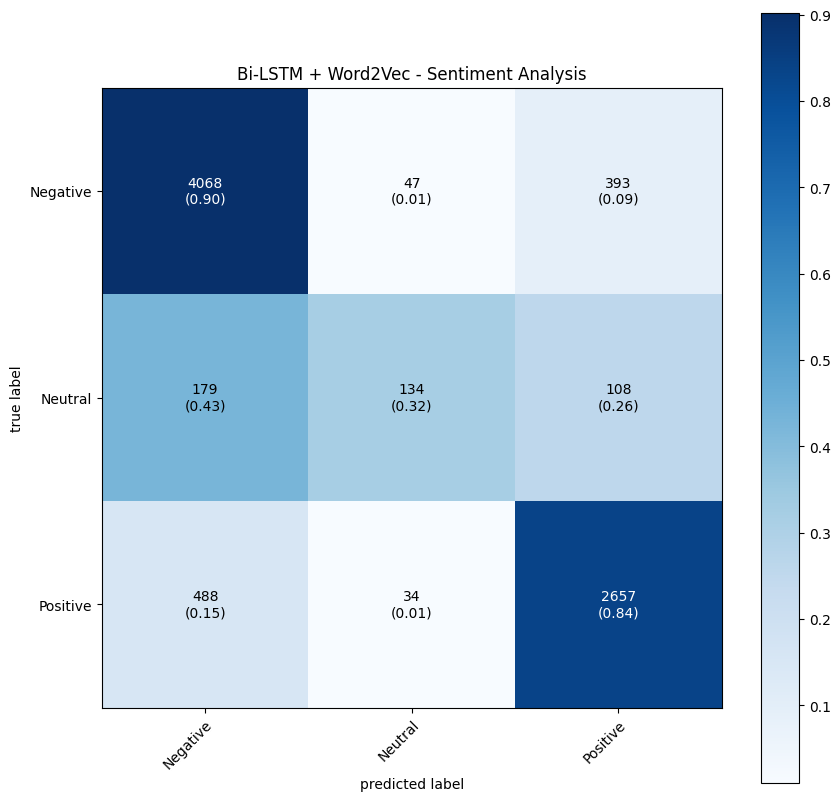

In [33]:
model_cm = confusion_matrix(true_labels_test, model_pred_test)
fig, ax = plot_confusion_matrix(conf_mat=model_cm, show_absolute=True, show_normed=True, colorbar=True, class_names=["Negative", "Neutral", "Positive"], figsize=(10, 10))
plt.title("Bi-LSTM + Word2Vec - Sentiment Analysis")
plt.savefig("./output/bilstm_word2vec.png")
plt.show()